In [2]:
# Load NeuroKit and other useful packages
%matplotlib widget


import neurokit2 as nk

import numpy as np 
import pandas as pd
import os

import csv
import itertools
import collections
import pywt

from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [3]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

In [43]:
path = '../Fractal Analysis/mitbih_database//mitbih_database/'
window_size = 200
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [44]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()



In [45]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)




Data Extraction and Preprocessing


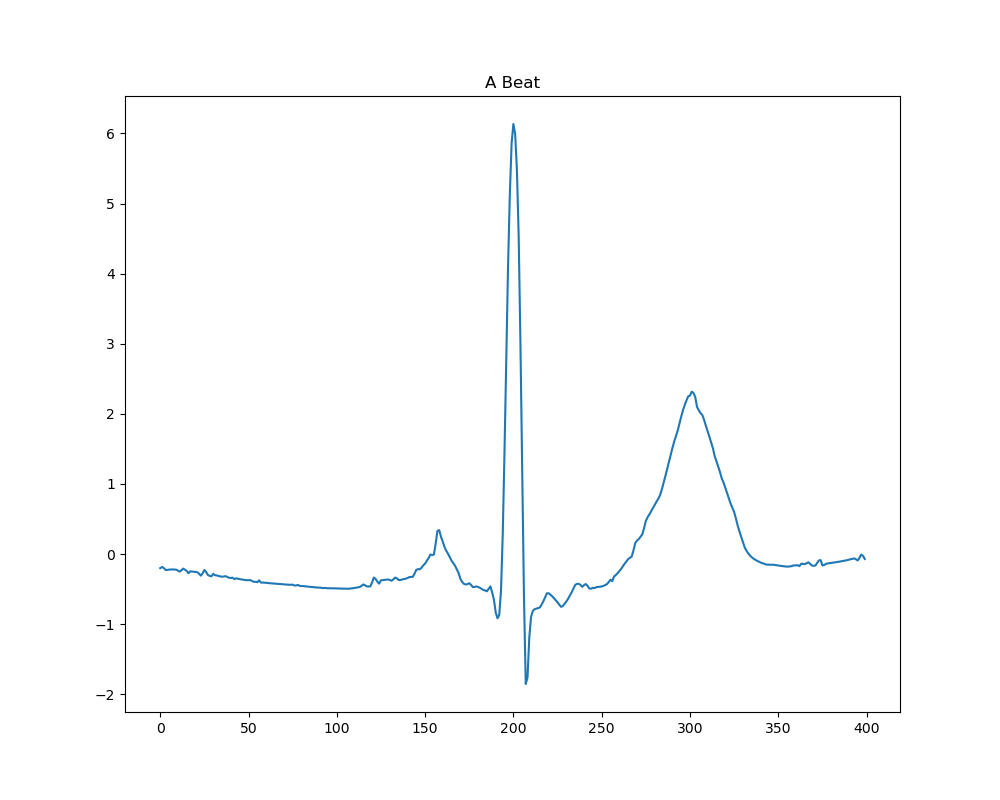

(100004, 400) (100004,)


In [46]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    #if r == 6:
        # Plot each patient's signal
        #plt.title(records[6] + " Wave")
        #plt.plot(signals[0:700])
        #plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    #if r == 6:
        # Plot each patient's signal
        #plt.title(records[6] + " wave after denoised")
        #plt.plot(signals[0:700])
        #plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    #if r == 6:
        # Plot each patient's signal
        #plt.title(records[6] + " wave after z-score normalization ")
        #plt.plot(signals[0:700])
        #plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ') #The split() method splits a string into a list.
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
           # if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
                #    pass
            #else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r == 6 and not example_beat_printed: 
                        plt.figure(figsize=(10,8))
                        plt.title("A Beat")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

In [47]:
count_classes

[75052, 8075, 7259, 2546, 7130]

In [48]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100004, 401)


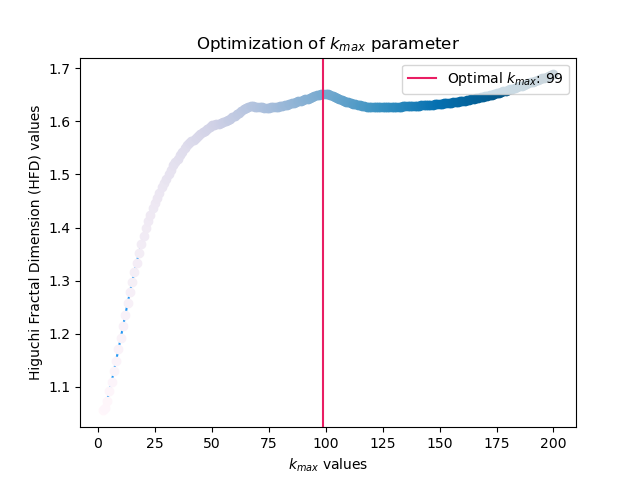

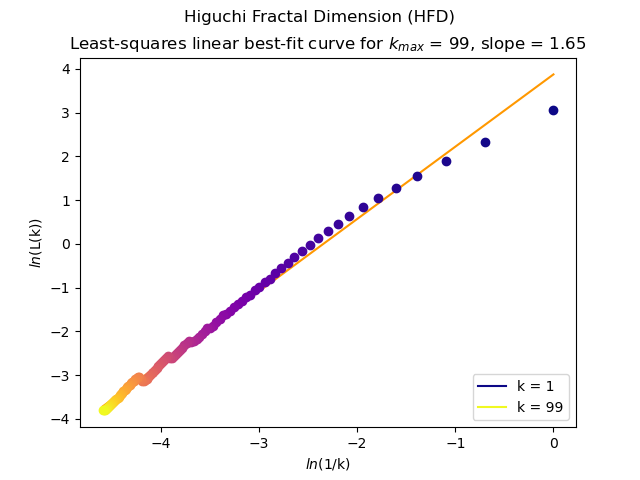

In [49]:
k_max, info =  nk.complexity_k(X[7], k_max='default', show=True)

hfd, info = nk.fractal_higuchi(X[7], k_max=k_max, show=True)


0.0    75005
1.0     8070
2.0     7254
4.0     7129
3.0     2546
Name: 400, dtype: int64


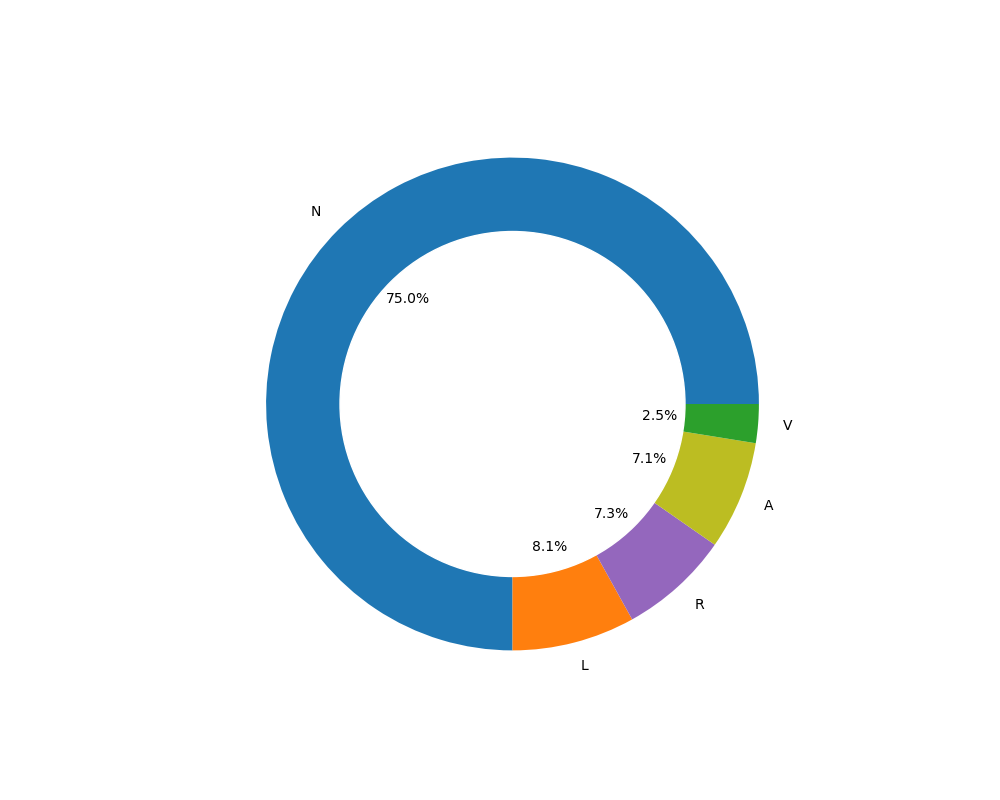

In [57]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(10,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

Rebalancing Classes

In [58]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: 400, dtype: int64


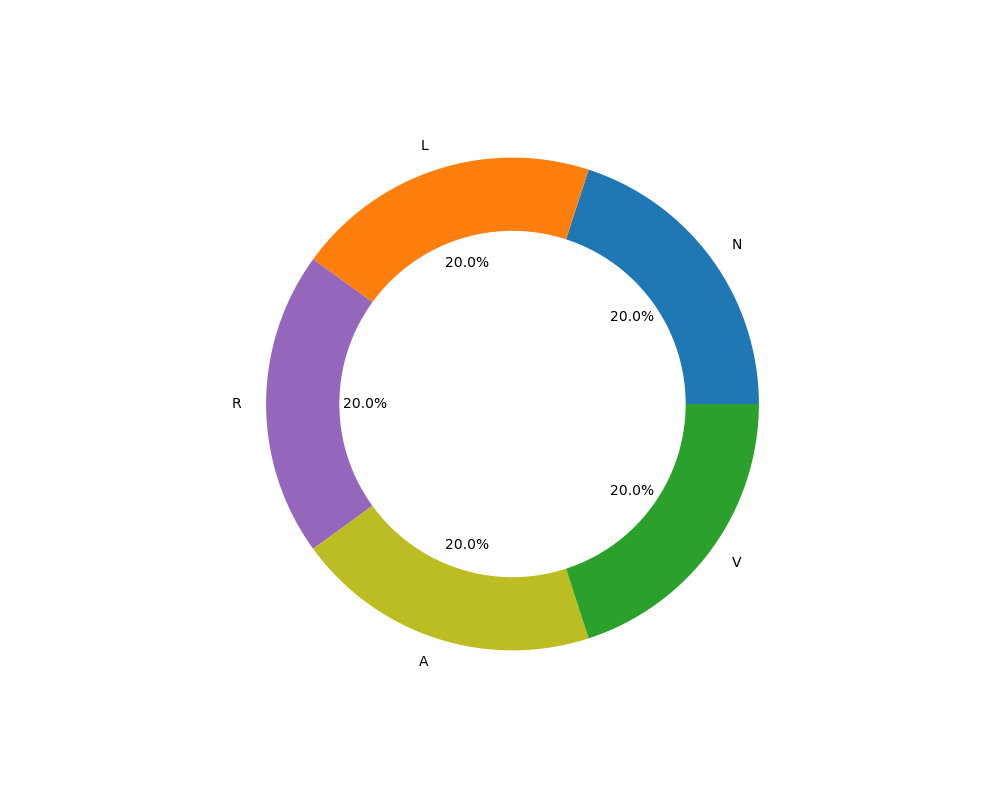

In [64]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(10,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()


In [65]:
per_class

0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: 400, dtype: int64

In [66]:
beatdata = X_train_df.to_numpy()

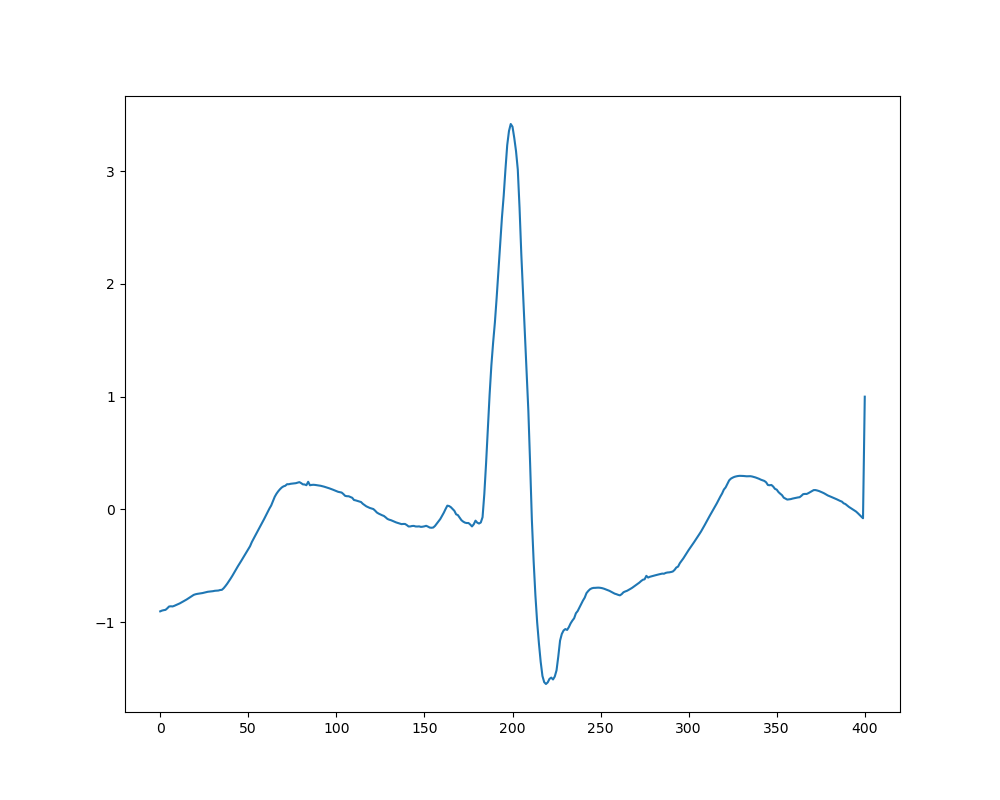

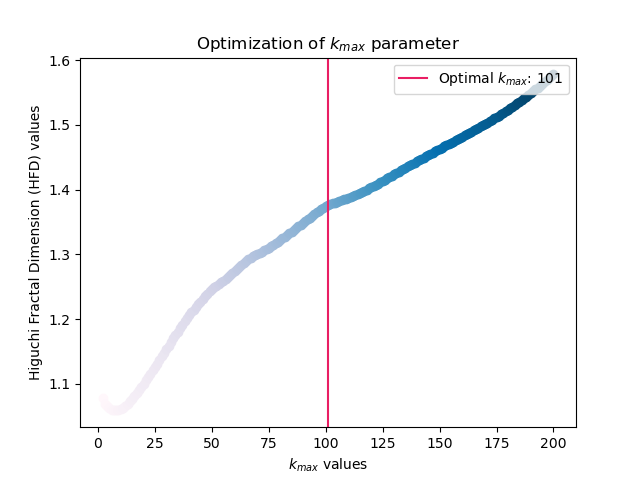

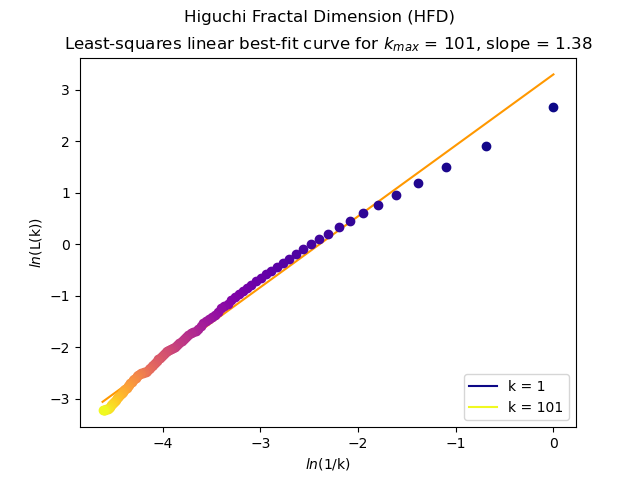

In [67]:
fig = plt.figure(figsize=(10,8))
plt.plot(beatdata[8000])

k_max, info =  nk.complexity_k(beatdata[8000], k_max='default', show=True)

hfd, info = nk.fractal_higuchi(beatdata[8000], k_max=k_max, show=True)

plt.plot(beatdata[6000])
k_max, info =  nk.complexity_k(beatdata[6000], k_max='default', show=False)

hfd, info = nk.fractal_higuchi(beatdata[6000], k_max=k_max, show=False)


plt.plot(beatdata[11000])
k_max, info =  nk.complexity_k(beatdata[11000], k_max='default', show=False)

hfd, info = nk.fractal_higuchi(beatdata[11000], k_max=k_max, show=False)

plt.plot(beatdata[16000])
k_max, info =  nk.complexity_k(beatdata[16000], k_max='default', show=False)

hfd, info = nk.fractal_higuchi(beatdata[16000], k_max=k_max, show=False)

In [68]:
fdim0 = np.zeros(200)
h0 = np.zeros(200)
cd0 = np.zeros(200)
lle0 = np.zeros(200)

for i in range(0,200):
    k_max, info =  nk.complexity_k(beatdata[1000+i], k_max='default', show=False)

    hfd, info = nk.fractal_higuchi(beatdata[1000+i], k_max=k_max, show=False)
    h, info = nk.fractal_hurst(beatdata[1000+i], corrected=True, show=False)
    cd, info = nk.fractal_correlation(beatdata[1000+i], radius=32, show=False)

    lle, info = nk.complexity_lyapunov(beatdata[1000+i], method="rosenstein1993", show=False)


    fdim0[i] = hfd
    h0[i] = h
    cd0[i] = cd
    lle0[i] = lle

In [ ]:
fdim1 = np.zeros(200)
h1 = np.zeros(200)
cd1 = np.zeros(200)
lle1 = np.zeros(200)

for i in range(0,200):
    k_max, info =  nk.complexity_k(beatdata[6000+i], k_max='default', show=False)

    hfd, info = nk.fractal_higuchi(beatdata[6000+i], k_max=k_max, show=False)
    h, info = nk.fractal_hurst(beatdata[6000+i], corrected=True, show=False)
    cd, info = nk.fractal_correlation(beatdata[6000+i], radius=32, show=False)

    lle, info = nk.complexity_lyapunov(beatdata[6000+i], method="rosenstein1993", show=False)


    fdim1[i] = hfd
    h1[i] = h
    cd1[i] = cd
    lle1[i] = lle

In [ ]:
fdim2 = np.zeros(200)
h2 = np.zeros(200)
cd2 = np.zeros(200)
lle2 = np.zeros(200)

for i in range(0,200):
    k_max, info =  nk.complexity_k(beatdata[11000+i], k_max='default', show=False)

    hfd, info = nk.fractal_higuchi(beatdata[11000+i], k_max=k_max, show=False)
    h, info = nk.fractal_hurst(beatdata[11000+i], corrected=True, show=False)
    cd, info = nk.fractal_correlation(beatdata[11000+i], radius=32, show=False)

    lle, info = nk.complexity_lyapunov(beatdata[11000+i], method="rosenstein1993", show=False)


    fdim2[i] = hfd
    h2[i] = h
    cd2[i] = cd
    lle2[i] = lle

In [ ]:
fdim3 = np.zeros(200)
h3 = np.zeros(200)
cd3 = np.zeros(200)
lle3 = np.zeros(200)

for i in range(0,200):
    k_max, info =  nk.complexity_k(beatdata[16000+i], k_max='default', show=False)

    hfd, info = nk.fractal_higuchi(beatdata[16000+i], k_max=k_max, show=False)
    h, info = nk.fractal_hurst(beatdata[16000+i], corrected=True, show=False)
    cd, info = nk.fractal_correlation(beatdata[16000+i], radius=32, show=False)

    lle, info = nk.complexity_lyapunov(beatdata[16000+i], method="rosenstein1993", show=False)


    fdim3[i] = hfd
    h3[i] = h
    cd3[i] = cd
    lle3[i] = lle


In [ ]:
#plt.plot(beatdata[21000])

fdim4 = np.zeros(200)
h4 = np.zeros(200)
cd4 = np.zeros(200)
lle4 = np.zeros(200)

for i in range(0,200):
    k_max, info =  nk.complexity_k(beatdata[22000+i], k_max='default', show=False)

    hfd, info = nk.fractal_higuchi(beatdata[22000+i], k_max=k_max, show=False)
    h, info = nk.fractal_hurst(beatdata[22000+i], corrected=True, show=False)
    cd, info = nk.fractal_correlation(beatdata[22000+i], radius=32, show=False)

    lle, info = nk.complexity_lyapunov(beatdata[22000+i], method="rosenstein1993", show=False)

    
    fdim4[i] = hfd
    h4[i] = h
    cd4[i] = cd
    lle4[i] = lle



In [ ]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(fdim0, h0, cd0)
ax.scatter(fdim1, h1, cd1)
ax.scatter(fdim2, h2, cd2)
ax.scatter(fdim3, h3, cd3)
ax.scatter(fdim4, h4, cd4)

ax.set_xlabel('Higuchi Fractal Dimension')
ax.set_ylabel('Hurst Exponent')
ax.set_zlabel('Correlation dimension')
#ax.set_title("Higuchi fractal dimension vs Hurst exponent vs Correlation Dimension for 2 arrythmias")
ax.set_title("Higuchi fractal dimension vs Hurst exponent vs Correlation Dimension for 2 arrythmias and NSR")

plt.show()



fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(fdim1, h1, cd1)
ax.scatter(fdim2, h2, cd2)

ax.set_xlabel('Higuchi Fractal Dimension')
ax.set_ylabel('Hurst Exponent')
ax.set_zlabel('Correlation dimension')
ax.set_title("Higuchi fractal dimension vs Hurst exponent vs Correlation Dimension for 2 arrythmias")

ax.view_init(80, 90)



In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Ndim = np.insert(np.stack((fdim0, h0, cd0, lle0), axis = 1),0,0, axis=1)
Ldim = np.insert(np.stack((fdim1, h1, cd1, lle1), axis = 1),0,1, axis=1)
Rdim = np.insert(np.stack((fdim2, h2, cd2, lle2), axis = 1),0,2, axis=1)
Adim = np.insert(np.stack((fdim3, h3, cd3, lle3), axis = 1),0,3, axis=1)
Vdim = np.insert(np.stack((fdim4, h4, cd4, lle4), axis = 1),0,4, axis=1)

labels= np.array(np.concatenate((Ndim[:, 0], Ldim[:, 0],Rdim[:, 0], Adim[:, 0], Vdim[:, 0])), dtype=object)
Xfdim = np.array(np.concatenate((Ndim[:, 1], Ldim[:, 1],Rdim[:, 1], Adim[:, 1], Vdim[:, 1])), dtype=object)
Xh = np.array(np.concatenate((Ndim[:, 2], Ldim[:, 2],Rdim[:, 2], Adim[:, 2], Vdim[:, 2])), dtype=object)
Xcd = np.array(np.concatenate((Ndim[:, 3], Ldim[:, 3],Rdim[:, 3], Adim[:, 3], Vdim[:, 3])), dtype=object)
Xlle = np.array(np.concatenate((Ndim[:, 4], Ldim[:, 4],Rdim[:, 4], Adim[:, 4], Vdim[:, 4])), dtype=object)


X = np.stack((labels, Xfdim, Xh, Xcd, Xlle), axis =1)




names = ['Type', 'FD', "Hurst", 'CD', 'LLE']
labels_df = X[:, 0]

df = pd.DataFrame(X, columns = names)

standardized_data = StandardScaler().fit_transform(df)
data_1000 = standardized_data



pca = PCA(n_components=3)
#Npca = pca.fit_transform(Ndim)
#Lpca = pca.fit_transform(Ldim)
#Rpca = pca.fit_transform(Rdim)
#Apca = pca.fit_transform(Adim)
#Vpca = pca.fit_transform(Vdim)




In [ ]:
from code import interact
from tkinter import Y
from sklearn.manifold import TSNE
import seaborn as sn
from mpl_toolkits.mplot3d import axes3d 



tsne = TSNE(n_components=3,  random_state=0, perplexity=80,early_exaggeration=3, n_iter=2000, learning_rate = 100, n_iter_without_progress=300, angle=0.5)
labels_1000 = labels_df
Xtsne = tsne.fit_transform(data_1000)

tsne_data = np.vstack((Xtsne.T, labels_1000)).T


tsne_data

sn.set(style = "darkgrid")

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')


tsne_df = pd.DataFrame(tsne_data, columns = ('1st Component', '2nd Component', '3rd Component', 'Type'))

sn.FacetGrid(tsne_df, hue = 'Type', aspect = 2, height = 5).map(plt.scatter, '1st Component', '2nd Component').add_legend()


x = tsne_df["1st Component"].to_numpy()
y = tsne_df["2nd Component"].to_numpy()
z = tsne_df["3rd Component"].to_numpy()

ax.scatter(x[:200],y[:200], z[:200], s=10, c = 'red', cmap=plt.cm.prism, label = 0, alpha = 1)
ax.scatter(x[200:400],y[200:400], z[200:400], s = 10, c = 'green', cmap=plt.cm.prism, label = 1, alpha = 1)
ax.scatter(x[400:600],y[400:600], z[400:600], s = 10, c = 'blue', cmap=plt.cm.prism, label = 2, alpha = 1)
ax.scatter(x[600:800],y[600:800], z[600:800], s = 10, c = 'purple', cmap=plt.cm.prism, label = 3, alpha = 1)
ax.scatter(x[800:1000],y[800:1000], z[800:1000], s = 10, c = 'orange', cmap=plt.cm.prism, label = 4, alpha = 1)

#z[:100]

ax.legend()


for angle in range(0, 360):
   ax.view_init(30, angle)
  


plt.show()



